# 0. Preparation

In [2]:
import numpy as np
import heapq
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

## 0.1. load data

In [3]:
# 資料位置設置
data_path = "../data/ratings.data"

# 讀取資料
data = np.loadtxt(data_path, dtype=int)
print(data.shape)
print(data[:5])

(100000, 4)
[[      196       242         3 881250949]
 [      186       302         3 891717742]
 [       22       377         1 878887116]
 [      244        51         2 880606923]
 [      166       346         1 886397596]]


In [4]:
# 存取使用者及電影名稱
user = np.unique(data[:,0])
movie = np.unique(data[:,1])
print(user.shape, movie.shape)

(943,) (1682,)


## 0.2. split training data & testing data

In [5]:
# 將資料切分為訓練資料及測試資料
train_data, test_data = train_test_split(data, test_size = 0.25, random_state=42)
print(train_data.shape, test_data.shape)

(75000, 4) (25000, 4)


# 1. Collaborative Filtering (CF)

In [6]:
# 針對向量非0地方做計算
def non_zero_mean(arr):
    exist = arr != 0
    total = arr.sum(axis = 1)
    exist_number = exist.sum(axis=1)
    
    return np.reshape(total/exist_number, (-1, 1))

# 針對單一向量非0地方做計算
def non_zero_vec_mean(vec):
    exist = vec != 0
    total = vec.sum()
    if total == 0: return 0
    exist_number = exist.sum()
    
    return total/exist_number


# 取得整體平均
def get_u():    
    return np.mean(non_zero_mean(user_matrix))
    
    
# 計算向量長度
def norm(v):
    return np.sqrt(np.sum(np.power(v, 2)))

# 計算兩個向量的 cosine 相似度
def cos_sim(a, b):
    s = norm(a)*norm(b)
    if s == 0:
        return 0
    
    return np.inner(a,b) / s

# 計算兩個向量的 Pearson Correlation Coefficient 相似度
def pcc_sim(a, b):
    mean_a = non_zero_vec_mean(a)
    mean_b = non_zero_vec_mean(b)
    s = np.sqrt(np.sum(np.power((a-mean_a), 2))) * np.sqrt(np.sum(np.power((b-mean_b), 2)))
    if s == 0:
        return 0
    
    return np.inner(a-mean_a, b-mean_b) / s
    

# 計算兩兩之間的相似度，且自己與自己的相似度調整為0
def get_sim_dict(target, arr):
    # init 目標相似度名單(cos & pcc)
    cos_dict = dict()
    pcc_dict = dict()
    
    for u in tqdm(range(len(target)), desc='caculator u & v similar'):
        # init 目標 u 跟 v 的相似度
        uv_cos = list()
        uv_pcc = list()
        for v in range(len(target)):
            if u != v:
                # 計算使用者u、v的cosine
                uv_cos.append(cos_sim(arr[u], arr[v]))
                uv_pcc.append(pcc_sim(arr[u], arr[v]))
            else:
                # 為了保持index不會跑掉，因此在自己的位置不做計算且補0
                uv_cos.append(0)
                uv_pcc.append(0)

        cos_dict[u] = uv_cos
        pcc_dict[u] = uv_pcc        
    
    return cos_dict, pcc_dict

# 推測評分
def predict(S, R):
    s = np.sum(S)
    if s == 0:
        return 0
    
    return np.dot(S,R)/ s

# Vistualize Result
def plot_result(df, title):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.figure(figsize=(15,10))
    plt.title(title)
    for c in df.columns:
        if c != "K":
            g = sns.lineplot(data=df, x="K", y=c, label=c)
    g.set(ylabel = "RMSE")

# Vistualize Testing & Training Result
def plot_training_testing(df, ax, title):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    ax.set_title(title)
    for c in df.columns:
        if c != "K":
            g = sns.lineplot(ax=ax, data=df, x="K", y=c, label=c)
    g.set(ylabel = "RMSE")
    
# item bias
def get_ibias(i):
    return non_zero_vec_mean(user_matrix[:,i]) 

# user bias
def get_ubias(u):
    return non_zero_vec_mean(user_matrix[u]) 

# 偏差修正
def get_bias(arr):
    # 計算bias
    bias_matrix = np.zeros((len(user), len(movie)))
    mean = get_u()

     # init u + bu
    for u in range(bias_matrix.shape[0]):
        bias_matrix[u] = get_ubias(u)

    # Bias = u + bu + bi
    for i in range(bias_matrix.shape[1]):
        bias_matrix[:,i] += get_ibias(i) - mean

    # 刪除原本沒有評分的bias
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i,j] == 0:
                bias_matrix[i,j] = 0
    
    return bias_matrix

# square error
def se(t, p):
    return (p-t)**2

# rmse
def rmse(delta_list):
    if len(delta_list)==0:
        return None
    
    return (sum(delta_list)/len(delta_list))**0.5

## 1.1. User-based Collaborative Filtering (U-CF)

In [10]:
# init user_matrix as zero matrix
user_matrix = np.zeros((len(user), len(movie)))

for u in tqdm(user, desc='data transfer user matrix'):
    '''
    train_data[train_data[:,0] == u] : 過濾出u使用者所有的評分資料
    train_data[train_data[:,0] == u][:,1]: 取得u使用者所有評分過的電影名稱
    '''
    rate_index = train_data[train_data[:,0] == u][:,1]
    for rate in rate_index:
        '''
        user_matrix[u-1, rate-1]: 欲設置的rateing位置
        train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)]: 取出u使用者對於評論過特定電影的資料
        '''
        user_matrix[u-1, rate-1] = train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)][:,2].item()

data transfer user matrix: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:13<00:00, 70.98it/s]


In [52]:
# 計算使用者平均評分
user_mean = non_zero_mean(user_matrix)
# 使用個別使用者平均校正使用者對電影的評分
# user_adjust = np.where(user_matrix == 0, user_matrix, user_matrix-user_mean)
user_adjust = user_matrix - np.mean(user_matrix, axis=1).reshape(-1, 1)
print(f"user_matrix:\n{user_matrix} \n\nafter adjust:\n{user_adjust}")

user_matrix:
[[0. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]] 

after adjust:
[[-0.4351962   2.5648038   3.5648038  ... -0.4351962  -0.4351962
  -0.4351962 ]
 [ 3.9019025  -0.0980975  -0.0980975  ... -0.0980975  -0.0980975
  -0.0980975 ]
 [-0.07015458 -0.07015458 -0.07015458 ... -0.07015458 -0.07015458
  -0.07015458]
 ...
 [ 4.96016647 -0.03983353 -0.03983353 ... -0.03983353 -0.03983353
  -0.03983353]
 [-0.15338882 -0.15338882 -0.15338882 ... -0.15338882 -0.15338882
  -0.15338882]
 [-0.25743163  4.74256837 -0.25743163 ... -0.25743163 -0.25743163
  -0.25743163]]


In [110]:
# 計算bias
bias_matrix = get_bias(user_matrix)

# 取得user間的相似度名單
cos_dict, pcc_dict = get_sim_dict(user, user_matrix)

caculator u & v similar: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [02:27<00:00,  6.38it/s]


### 1.1.1.  User‐Based CF use Cosine result

In [122]:
# 與不同K個使用者相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
ucf_cos = list()

# 針對不同相似使用者個數進行分析
for k in K:
    predict_matrix = np.zeros((len(user), len(movie)))
    delta_list = list()
    # 取出前K個相似度最大的電影名稱，並設置於N
    for i in tqdm(cos_dict.keys(), desc=f"predicting K = {k}"):
        # Suv: 取出前K個最相似的使用者相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Suv = heapq.nlargest(k,cos_dict[i])
        # top_sim_index: 取出前K個最相似的使用者相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(cos_dict[i].index, heapq.nlargest(k,cos_dict[i])))
        # 利用相似的使用者對使用者i的每一部電影做評分預測
        for m in range(len(movie)):
            # ground truth
            rth = user_matrix[i, m]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Suv = copy.deepcopy(Suv)
                # R: 若相似使用者對電影 m 有評分則進行調整
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  user_matrix[j, m] == 0:
                        R.append(0)
                        copy_Suv[c] = 0
                    else:
                        R.append(user_matrix[j, m] - bias_matrix[j, m])

                # 預測使用者u對於第m部電影的評分 + 使用者i及電影m的偏差
                Rui = predict(copy_Suv, R) + bias_matrix[i, m]
                # predict_matrix[i, m] = Rui
                # 計算RMSE
                delta_list.append(se(rth, Rui))
    ucf_cos.append(rmse(delta_list))

predicting K = 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:14<00:00, 64.70it/s]


### 1.1.2. User‐Based CF use Pearson Correlation Coefficient result

In [121]:
# 與不同K個使用者相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
ucf_pcc = list()

# 針對不同相似使用者個數進行分析
for k in K:
    predict_matrix = np.zeros((len(user), len(movie)))
    delta_list = list()
    # 取出前K個相似度最大的電影名稱，並設置於N
    for i in tqdm(pcc_dict.keys(), desc=f"predicting K = {k}"):
        # Suv: 取出前K個最相似的使用者相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Suv = heapq.nlargest(k,pcc_dict[i])
        # top_sim_index: 取出前K個最相似的使用者相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(pcc_dict[i].index, heapq.nlargest(k,pcc_dict[i])))
        # 利用相似的使用者對使用者u的每一部電影做評分預測
        for m in range(len(movie)):
            # ground truth
            rth = user_matrix[i, m]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Suv = copy.deepcopy(Suv)
                # R: 若相似使用者對電影 m 有評分則進行調整
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  user_matrix[j, m] == 0:
                        R.append(0)
                        copy_Suv[c] = 0
                    else:
                        R.append(user_matrix[j, m] - bias_matrix[j, m])

                # 預測使用者u對於第m部電影的評分
                Rui = predict(copy_Suv, R) + bias_matrix[i, m]
                # predict_matrix[i, m] = Rui
                # 計算RMSE
                delta_list.append(se(rth, Rui))
    ucf_pcc.append(rmse(delta_list))

predicting K = 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:13<00:00, 68.42it/s]


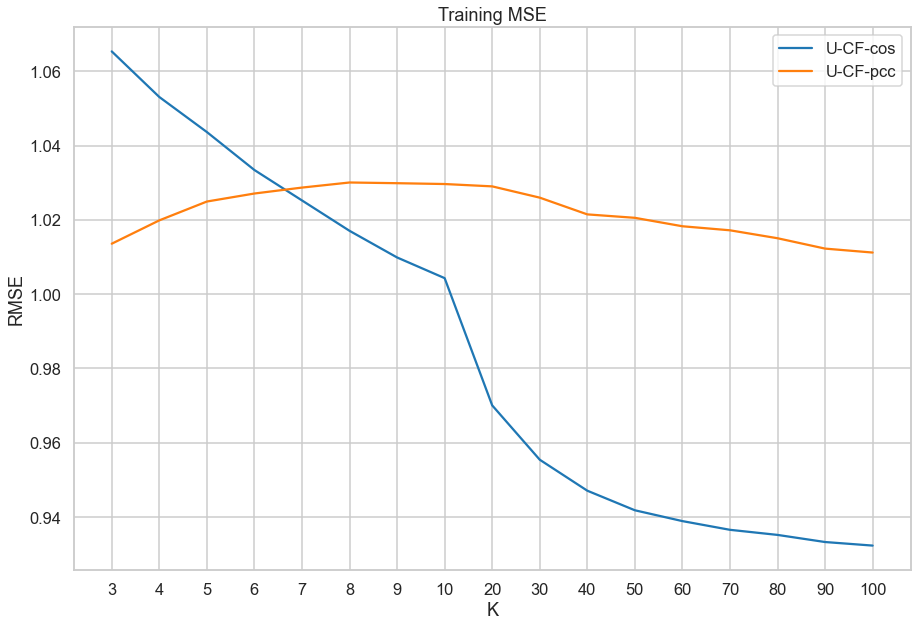

In [123]:
# 將K轉成字串形式
str_k = list(map(lambda x:str(x), K))
# numpy to pandas
df = pd.DataFrame({"K": str_k, "U-CF-cos":ucf_cos, "U-CF-pcc":ucf_pcc})
# Visualize
plot_result(df, "Training MSE")

## 1.2. Item-based Collaborative Filtering (I-CF)

In [15]:
# Transpose user_matrix as movie_matrix, bias_matrix as movie_bias.
movie_matrix = user_matrix.T
movie_bias = bias_matrix.T
movie_matrix.shape, movie_bias.shape

((1682, 943), (1682, 943))

#### ＃電影校正後會產生zero vec故在這裡不採用校正後matrix算相似度 

In [37]:
# 計算電影平均評分
# movie_mean = non_zero_mean(movie_matrix)
# # 使用個別電影平均校正電影對使用者的評分
# # movie_adjust = np.where(movie_matrix == 0, movie_matrix, movie_matrix-movie_mean)
# movie_adjust = movie_matrix - np.mean(movie_matrix, axis=1).reshape(-1, 1)
# print(f"movie_matrix:\n{movie_matrix} \n\nafter adjust:\n{movie_adjust}")

movie_matrix:
[[0. 4. 0. ... 5. 0. 0.]
 [3. 0. 0. ... 0. 0. 5.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

after adjust:
[[-1.30965005e+00  2.69034995e+00 -1.30965005e+00 ...  3.69034995e+00
  -1.30965005e+00 -1.30965005e+00]
 [ 2.67020148e+00 -3.29798515e-01 -3.29798515e-01 ... -3.29798515e-01
  -3.29798515e-01  4.67020148e+00]
 [ 3.78685048e+00 -2.13149523e-01 -2.13149523e-01 ... -2.13149523e-01
  -2.13149523e-01 -2.13149523e-01]
 ...
 [-2.12089077e-03 -2.12089077e-03 -2.12089077e-03 ... -2.12089077e-03
  -2.12089077e-03 -2.12089077e-03]
 [-3.18133616e-03 -3.18133616e-03 -3.18133616e-03 ... -3.18133616e-03
  -3.18133616e-03 -3.18133616e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


C:\Users\Baron\AppData\Local\Temp/ipykernel_3124/2283623911.py:7: RuntimeWarning: invalid value encountered in true_divide
  return np.reshape(total/exist_number, (-1, 1))


In [125]:
# 取得movie間的相似度名單
cos_mdict, pcc_mdict = get_sim_dict(movie, movie_matrix)

caculator u & v similar: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [07:36<00:00,  3.68it/s]


### 1.2.1.  Item‐Based CF use Cosine result

In [126]:
# 與不同K個電影相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
icf_cos = list()

# 針對不同相似電影個數進行分析
for k in K:
    predict_matrix = np.zeros((len(movie), len(user)))
    delta_list = list()
    # 取出前K個相似度最大的使用者名稱，並設置於N
    for i in tqdm(cos_mdict.keys(), desc=f"predicting K = {k}"):
        # Siv: 取出前K個最相似的電影相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Siv = heapq.nlargest(k,cos_mdict[i])
        # top_sim_index: 取出前K個最相似的電影相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(cos_mdict[i].index, heapq.nlargest(k,cos_mdict[i])))
        # 利用相似的電影對電影的每一位使用者做評分預測
        for u in range(len(user)):
            # ground truth
            rth = movie_matrix[i, u]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Siv = copy.deepcopy(Siv)
                # R: 相似電影對調整後使用者 u 的評分
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  movie_matrix[j, u] == 0:
                        R.append(0)
                        copy_Siv[c] = 0
                    else:
                        R.append(movie_matrix[j, u] - movie_bias[j, u])

                # 預測使用者u對於第m部電影的評分
                Riu = predict(Siv, R) + movie_bias[i, u]
                # predict_matrix[i, u] = Riu
                # 計算RMSE
                delta_list.append(se(rth, Riu))
    icf_cos.append(rmse(delta_list))

predicting K = 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [00:15<00:00, 111.41it/s]


### 1.2.2.  Item‐Based CF use Pearson Correlation Coefficient result

In [127]:
# 與不同K個電影相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
icf_pcc = list()

# 針對不同相似電影個數進行分析
for k in K:
    predict_matrix = np.zeros((len(movie), len(user)))
    delta_list = list()
    # 取出前K個相似度最大的使用者名稱，並設置於N
    for i in tqdm(pcc_mdict.keys(), desc=f"predicting K = {k}"):
        # Siv: 取出前K個最相似的電影相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Siv = heapq.nlargest(k,pcc_mdict[i])
        # top_sim_index: 取出前K個最相似的電影相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(pcc_mdict[i].index, heapq.nlargest(k,pcc_mdict[i])))
        # 利用相似的電影對電影的每一位使用者做評分預測
        for u in range(len(user)):
            # ground truth
            rth = movie_matrix[i, u]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Siv = copy.deepcopy(Siv)
                # R: 相似電影對調整後使用者 u 的評分
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  movie_matrix[j, u] == 0:
                        R.append(0)
                        copy_Siv[c] = 0
                    else:
                        R.append(movie_matrix[j, u] - movie_bias[j, u])

                # 預測使用者u對於第m部電影的評分
                Riu = predict(Siv, R) + movie_bias[i, u]
                # predict_matrix[i, u] = Riu
                # 計算RMSE
                delta_list.append(se(rth, Riu))
    icf_pcc.append(rmse(delta_list))

predicting K = 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [00:15<00:00, 108.00it/s]


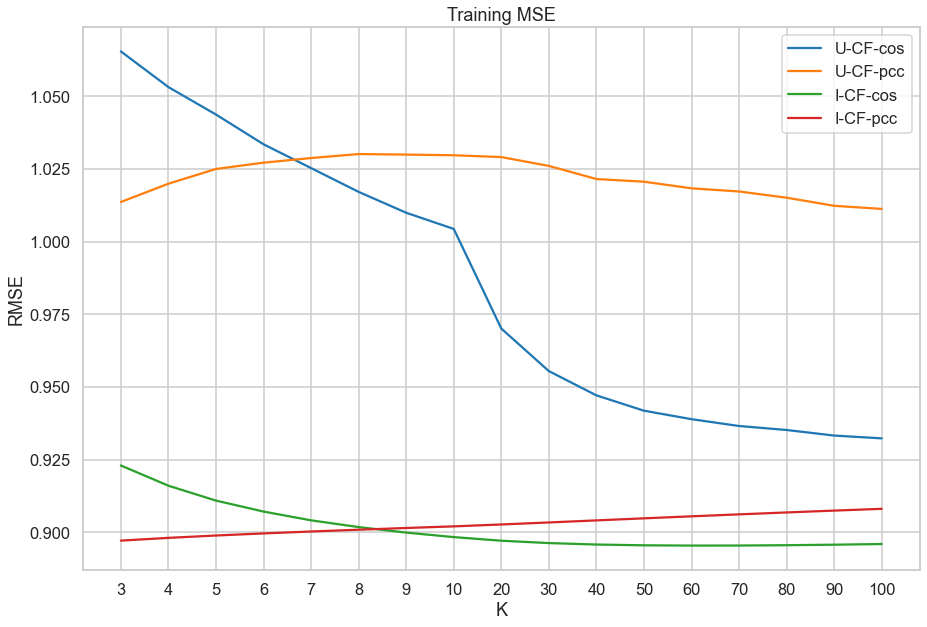

In [128]:
# numpy to pandas
df["I-CF-cos"] = icf_cos
df["I-CF-pcc"] = icf_pcc
# Visualize
plot_result(df, "Training MSE")

## 1.3. Testing U-CF

In [7]:
# init user_matrix as zero matrix
user_testing = np.zeros((len(user), len(movie)))

for u in tqdm(user, desc='data transfer user matrix'):
    '''
    train_data[train_data[:,0] == u] : 過濾出u使用者所有的評分資料
    train_data[train_data[:,0] == u][:,1]: 取得u使用者所有評分過的電影名稱
    '''
    rate_index = test_data[test_data[:,0] == u][:,1]
    for rate in rate_index:
        '''
        user_matrix[u-1, rate-1]: 欲設置的rateing位置
        train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)]: 取出u使用者對於評論過特定電影的資料
        '''
        user_testing[u-1, rate-1] = test_data[(test_data[:,0] == u) & (test_data[:,1] == rate)][:,2].item()

data transfer user matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 581.59it/s]


In [11]:
training = False

if training:
    print("Array Exist!!")

else:
    # 若bias不存在，則計算training bias
    print("Calculating Bias...")
    bias_matrix = get_bias(user_matrix)

    # 取得user間的相似度名單
    # 計算使用者平均評分
    user_mean = non_zero_mean(user_matrix)
    # # 使用個別使用者平均校正使用者對電影的評分
    # user_adjust = np.where(user_matrix == 0, user_matrix, user_matrix-user_mean)
    # print(f"user_matrix:\n{user_matrix} \n\nafter adjust:\n{user_adjust}")

    cos_dict, pcc_dict = get_sim_dict(user, user_matrix)

Calculating Bias...


caculator u & v similar: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [02:28<00:00,  6.34it/s]


### 1.3.1. Testing U-CF-cos

In [12]:
# 與不同K個使用者相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
ucf_tcos = list()

# 針對不同相似使用者個數進行分析
for k in K:
    predict_matrix = np.zeros((len(user), len(movie)))
    delta_list = list()
    # 取出前K個相似度最大的電影名稱，並設置於N
    for i in tqdm(cos_dict.keys(), desc=f"predicting K = {k}"):
        # Suv: 取出前K個最相似的使用者相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Suv = heapq.nlargest(k,cos_dict[i])
        # top_sim_index: 取出前K個最相似的使用者相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(cos_dict[i].index, heapq.nlargest(k,cos_dict[i])))
        # 利用相似的使用者對使用者i的每一部電影做評分預測
        for m in range(len(movie)):
            # ground truth
            rth = user_testing[i, m]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Suv = copy.deepcopy(Suv)
                # R: 相似電影對調整後使用者 u 的評分
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  user_testing[j, m] == 0:
                        R.append(0)
                        copy_Suv[c] = 0
                    else:
                        R.append(user_testing[j, m] - bias_matrix[j, m])

            # # R: 相似使用者對調整後電影 m 的評分
            # R = [user_testing[:,m][j] - bias_matrix[i, j] for j in top_sim_index]
            # 預測使用者u對於第m部電影的評分 + 使用者i及電影m的偏差
            Rui = predict(Suv, R) + bias_matrix[i, m]
            # predict_matrix[i, m] = Rui
            # 計算RMSE
            delta_list.append(se(rth, Rui))
    ucf_tcos.append(rmse(delta_list))

predicting K = 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:43<00:00, 21.80it/s]


### 1.3.2. Testing U-CF-pcc

In [13]:
# 與不同K個使用者相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
ucf_tpcc = list()

# 針對不同相似使用者個數進行分析
for k in K:
    predict_matrix = np.zeros((len(user), len(movie)))
    delta_list = list()
    # 取出前K個相似度最大的電影名稱，並設置於N
    for i in tqdm(pcc_dict.keys(), desc=f"predicting K = {k}"):
        # Suv: 取出前K個最相似的使用者相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Suv = heapq.nlargest(k,pcc_dict[i])
        # top_sim_index: 取出前K個最相似的使用者相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(pcc_dict[i].index, heapq.nlargest(k,pcc_dict[i])))
        # 利用相似的使用者對使用者i的每一部電影做評分預測
        for m in range(len(movie)):
            # ground truth
            rth = user_testing[i, m]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Suv = copy.deepcopy(Suv)
                # R: 相似電影對調整後使用者 u 的評分
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  user_testing[j, m] == 0:
                        R.append(0)
                        copy_Suv[c] = 0
                    else:
                        R.append(user_testing[j, m] - bias_matrix[j, m])
                        
            # # R: 相似使用者對調整後電影 m 的評分
            # R = [user_testing[:,m][j] - bias_matrix[i, j] for j in top_sim_index]
            # 預測使用者u對於第m部電影的評分 + 使用者i及電影m的偏差
            Rui = predict(Suv, R) + bias_matrix[i, m]
            # predict_matrix[i, m] = Rui
            # 計算RMSE
            delta_list.append(se(rth, Rui))
    ucf_tpcc.append(rmse(delta_list))

predicting K = 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:43<00:00, 21.56it/s]


## 1.4. Testing I-CF

In [16]:
movie_testing = user_testing.T

# 取得 bias
if training:
    print("Array Exist!!")

else:
    print("getting movie bias...")
    # Transpose user_matrix as movie_matrix, bias_matrix as movie_bias.
    movie_bias = bias_matrix.T
    
    # 取得movie間的相似度名單
    print("getting similarity...")
    cos_mdict, pcc_mdict = get_sim_dict(movie, movie_matrix)

getting movie bias...
getting similarity...


caculator u & v similar: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [07:35<00:00,  3.69it/s]


### 1.4.1. Testing I-CF-cos

In [17]:
# 與不同K個電影相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
icf_tcos = list()

# 針對不同相似電影個數進行分析
for k in K:
    predict_matrix = np.zeros((len(movie), len(user)))
    delta_list = list()
    # 取出前K個相似度最大的使用者名稱，並設置於N
    for i in tqdm(cos_mdict.keys(), desc=f"predicting K = {k}"):
        # Siv: 取出前K個最相似的電影相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Siv = heapq.nlargest(k,cos_mdict[i])
        # top_sim_index: 取出前K個最相似的電影相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(cos_mdict[i].index, heapq.nlargest(k,cos_mdict[i])))
        # 利用相似的電影對電影的每一位使用者做評分預測
        for u in range(len(user)):
            # ground truth
            rth = movie_testing[i, u]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Suv = copy.deepcopy(Suv)
                # R: 相似電影對調整後使用者 u 的評分
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  movie_testing[j, u] == 0:
                        R.append(0)
                        copy_Suv[c] = 0
                    else:
                        R.append(movie_testing[j, u] - movie_bias[j, u])
                        
            # # R: 相似電影對調整後使用者 u 的評分
            # R = [movie_testing[:,u][j] - movie_bias[i, j] for j in top_sim_index]
            # 預測使用者u對於第m部電影的評分
            Riu = predict(Siv, R) + movie_bias[i, u]
            # predict_matrix[i, u] = Riu
            # 計算RMSE
            delta_list.append(se(rth, Riu))
    icf_tcos.append(rmse(delta_list))

predicting K = 100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [00:43<00:00, 38.53it/s]


### 1.4.2. Testing I-CF-pcc

In [18]:
# 與不同K個電影相似程度比較
K = [3,4,5,6,7,8,9,10,20,30,40,50, 60,70,80,90,100]
icf_tpcc = list()

# 針對不同相似電影個數進行分析
for k in K:
    predict_matrix = np.zeros((len(movie), len(user)))
    delta_list = list()
    # 取出前K個相似度最大的使用者名稱，並設置於N
    for i in tqdm(pcc_mdict.keys(), desc=f"predicting K = {k}"):
        # Siv: 取出前K個最相似的電影相似度 ex:K=3, output=[0.378, 0.353, 0.336]
        Siv = heapq.nlargest(k,pcc_mdict[i])
        # top_sim_index: 取出前K個最相似的電影相似度(index) ex:K=3, output=[915, 406, 214]
        top_sim_index = list(map(pcc_mdict[i].index, heapq.nlargest(k,pcc_mdict[i])))
        # 利用相似的電影對電影的每一位使用者做評分預測
        for u in range(len(user)):
            # ground truth
            rth = movie_testing[i, u]
            # 如果原始評分不為0，則納入計算RMSE
            if rth != 0:
                # copy Suv
                copy_Suv = copy.deepcopy(Suv)
                # R: 相似電影對調整後使用者 u 的評分
                R = list()
                for c, j in enumerate(top_sim_index):
                    if  movie_testing[j, u] == 0:
                        R.append(0)
                        copy_Suv[c] = 0
                    else:
                        R.append(movie_testing[j, u] - movie_bias[j, u])
                        
            # # R: 相似電影對調整後使用者 u 的評分
            # R = [movie_testing[:,u][j] - movie_bias[i, j] for j in top_sim_index]
            # 預測使用者u對於第m部電影的評分
            Riu = predict(Siv, R) + movie_bias[i, u]
            # predict_matrix[i, u] = Riu
            # 計算RMSE
            delta_list.append(se(rth, Riu))
    icf_tpcc.append(rmse(delta_list))

predicting K = 100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682/1682 [00:44<00:00, 37.51it/s]


## 1.5. Training & Testing Result

In [19]:
# 將K轉成字串形式
str_k = list(map(lambda x:str(x), K))
# numpy to pandas
df_test = pd.DataFrame({"K": str_k, "U-CF-cos":ucf_tcos, "U-CF-pcc":ucf_tpcc, "I-CF-cos":icf_tcos, "I-CF-pcc":icf_tpcc})
df_test

,K,U-CF-cos,U-CF-pcc,I-CF-cos,I-CF-pcc
0,3,1.165222,1.013305,1.203750,0.975482
1,4,1.135065,0.998575,1.174316,0.965204
2,5,1.114338,0.985319,1.156180,0.960366
3,6,1.102331,0.978725,1.139073,0.958422
4,7,1.093507,0.969437,1.128360,0.955729
5,8,1.084284,0.964698,1.119274,0.952321
6,9,1.078564,0.961137,1.112424,0.950306
7,10,1.072028,0.959319,1.106573,0.948651
8,20,1.044643,0.946538,1.077959,0.941604
9,30,1.033799,0.940997,1.065221,0.938226


NameError: name 'df' is not defined

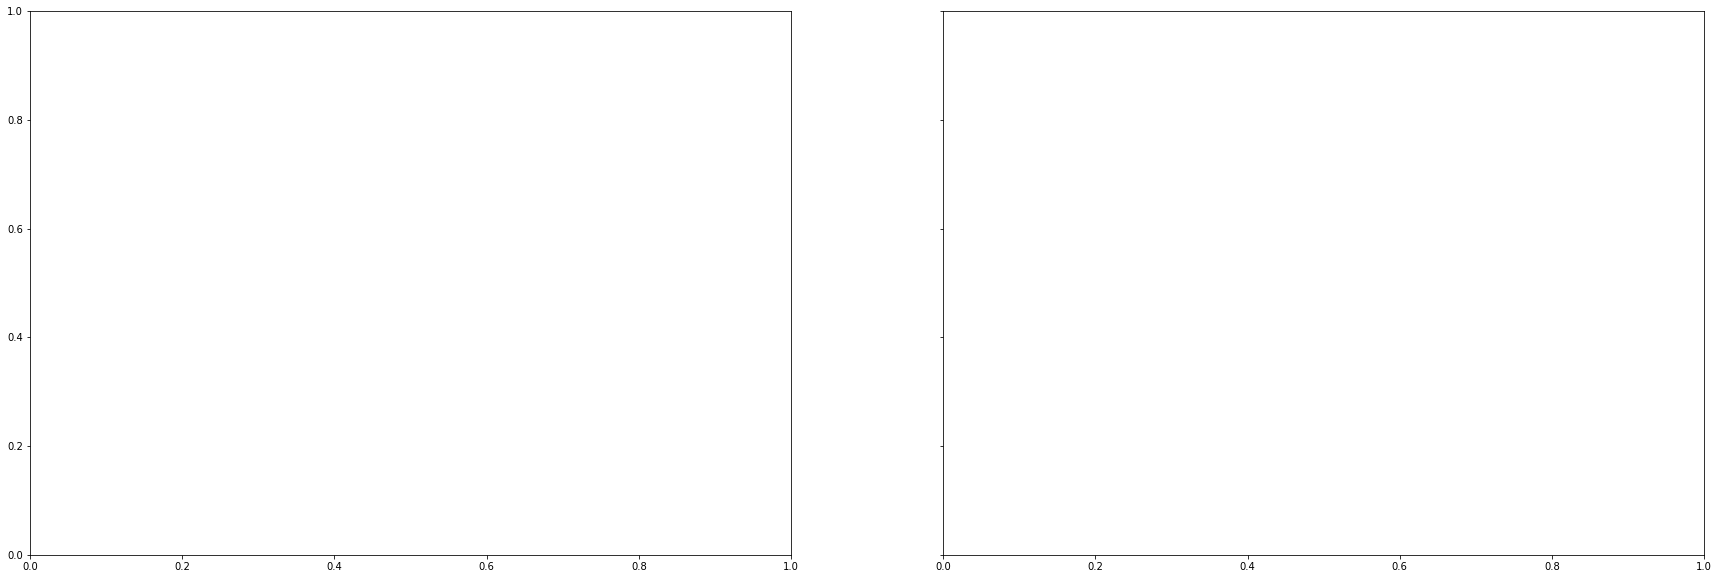

In [20]:
fig,axes=plt.subplots(1,2, figsize=(30,10), sharey=True)
plot_training_testing(df, axes[0], "Training RMSE")
plot_training_testing(df_test, axes[1], "Testing RMSE")

# 2. Latent Factor Model (Matrix Factorization)

In [ ]:
# 存取使用者及電影名稱
user = np.unique(data[:,0])
movie = np.unique(data[:,1])

# 訓練資料及測試資料
train_data.shape, test_data.shape

In [ ]:
# init user_matrix as zero matrix
user_item = np.zeros((len(user), len(movie)))

# 將資料轉成矩陣形式
for u in tqdm(user, desc='data transfer user matrix'):
    '''
    train_data[train_data[:,0] == u] : 過濾出u使用者所有的評分資料
    train_data[train_data[:,0] == u][:,1]: 取得u使用者所有評分過的電影名稱
    '''
    rate_index = train_data[train_data[:,0] == u][:,1]
    for rate in rate_index:
        '''
        user_matrix[u-1, rate-1]: 欲設置的rateing位置
        train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)]: 取出u使用者對於評論過特定電影的資料
        '''
        user_item[u-1, rate-1] = train_data[(train_data[:,0] == u) & (train_data[:,1] == rate)][:,2].item()

## 2.1. Initialize latent matrix

In [ ]:
# init lentent vector
K = 20
# init user lentent matrix
P = np.random.uniform(low=0, high=3, size=(len(user), K))
# init movie lentent matrix
Q = np.random.uniform(low=0, high=3, size=(len(movie), K))

## 2.2. Use SGD optimization algorithm update latent matrix

In [ ]:
# 設定SGD learning_rate
alpha = 0.01
# 設定正則化參數
l = 0.1

# 針對user有評分過的rating位置進行更新(User Latent Matrix)
for j in range(len(user)):
    # 找出使用者j對哪幾部電影評分的index
    movie_index = [i for i, e in enumerate(user_item[j]) if e != 0]
    for m in movie_index:
        # 若user item 有值則對Q的相對欄位進行SGD更新
        Q[m] -= alpha * ((np.dot(P[j], Q[m]) - user_item[j,m]) * P[j] + l*(Q[m]))

# 針對電影有被評分過的rating位置進行更新(Item Latent Matrix)
for m in range(len(movie)):
    # 找出使用者j對哪幾部電影評分的index
    user_index = [u for u, e in enumerate(user_item[:,m]) if e != 0]
    for j in user_index:
        # 若user item 有值則對Q的相對欄位進行SGD更新
        P[j] -= alpha * ((np.dot(P[j], Q[m]) - user_item[j,m]) * Q[m] + l*(P[j]))
 